# Modeling

## Introduction to Modeling
In the Titanic survival project, the modeling phase translates our cleaned, feature‑engineered data into actionable predictions.
Our objective is simple: learn a mapping from passenger attributes to the binary outcome “Survived / Did Not Survive.”

### To achieve this, we:

Frame the task as supervised classification – every passenger row is labeled with the ground‑truth outcome, allowing algorithms to learn from historical examples.
Select complementary algorithms –
Logistic Regression offers an interpretable, linear baseline that sets a performance floor and highlights feature coefficients.

Random Forest provides a powerful, non‑linear ensemble capable of capturing complex interactions missed by linear models.
Define evaluation criteria – beyond plain accuracy, we track precision, recall, F1‑score, ROC‑AUC, and confusion matrices to understand trade‑offs between false positives (predicting survival where none occurred) and false negatives (missing actual survivors).

Employ cross‑validated hyper‑parameter tuning – systematic grid searches ensure each model is fairly optimised on the training data while guarding against over‑fitting.
Hold out a test set – a 30 % stratified split remains untouched until final evaluation, giving us an unbiased glimpse of real‑world performance.


## Imports

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Load the Data and Train the Model

In [14]:
data = pd.read_csv('train.csv')
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True).dropna()
data['FamilySize'] = data['SibSp']+data['Parch']

In [15]:
X = data.drop(columns=['Survived'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
def train_and_evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name="Classifier"):
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Generate predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate evaluation metrics
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    # Print metrics
    print(f"=== {model_name} ===")
    print(f"Train Accuracy: {acc_train:.3f}")
    print(f"Test Accuracy: {acc_test:.3f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))
    
    # 1. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Confusion Matrix")
    plt.show()


    # 2. ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()


    # 3. Precision-Recall Curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.show()
    
    return model

## Logistic Regression

=== Logistic Regression ===
Train Accuracy: 0.804
Test Accuracy: 0.781
Precision: 0.780, Recall: 0.781, F1-score: 0.781
Confusion Matrix:
[[106  22]
 [ 25  62]]


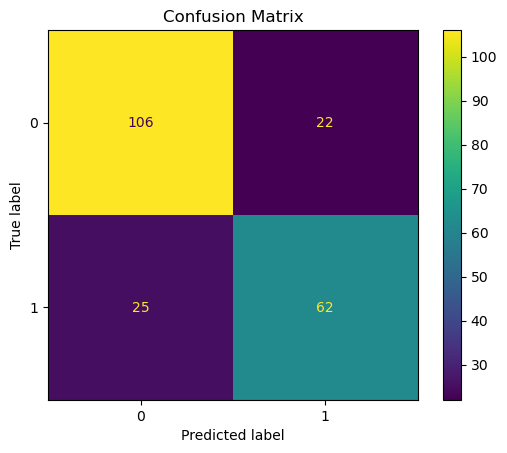

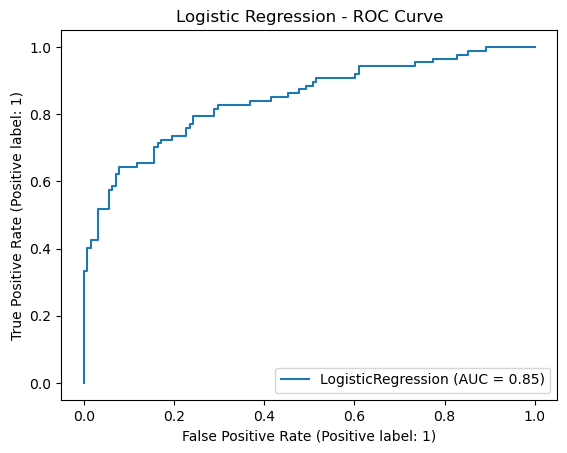

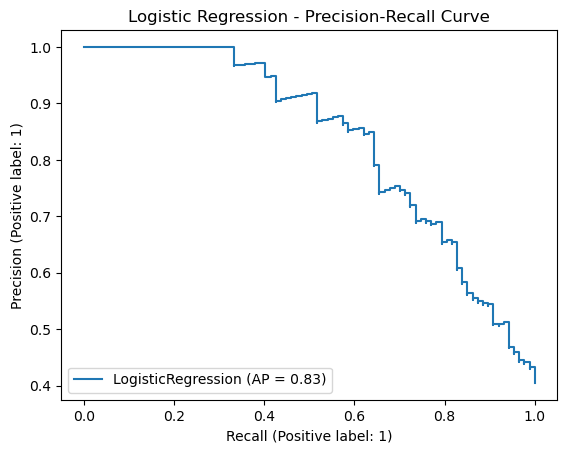

In [17]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
trained_logreg_model = train_and_evaluate_classifier(logreg_model, X_train, y_train, X_test, y_test, model_name="Logistic Regression")

## Grid Search Logistic Regrresion


=== Logistic‑Regression Grid‑Search Results ===
Best Parameters:     {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Accuracy:    0.8035
=== Logistic Regression (Best GridSearch) ===
Train Accuracy: 0.806
Test Accuracy: 0.786
Precision: 0.785, Recall: 0.786, F1-score: 0.785
Confusion Matrix:
[[107  21]
 [ 25  62]]


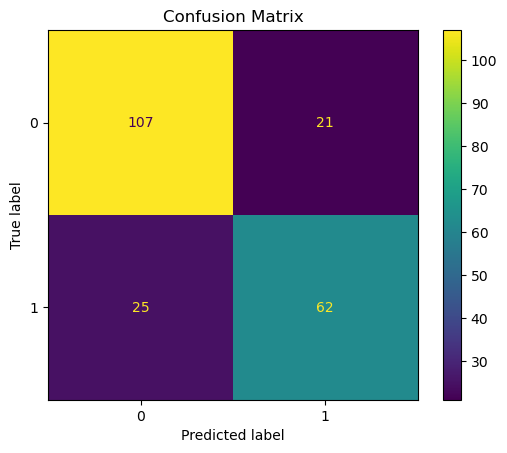

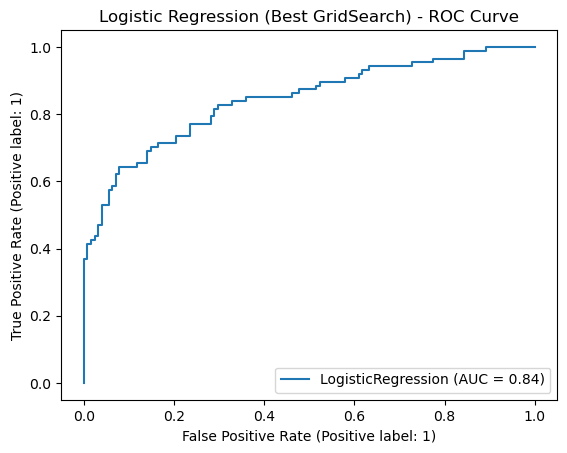

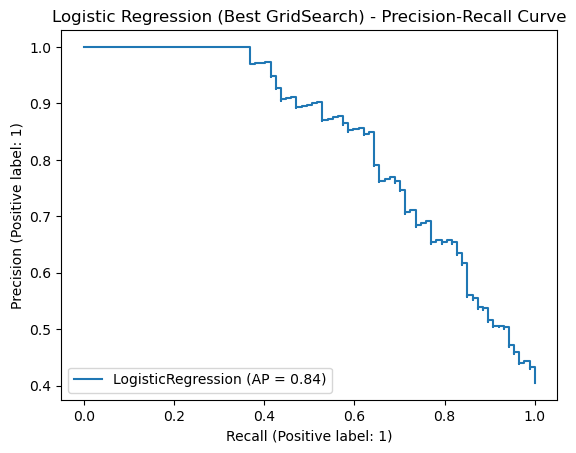

In [18]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C':       [0.01, 0.1, 1, 10, 100],
    'solver':  ['liblinear'],
}

lr_base = LogisticRegression(max_iter=1000, random_state=42)

grid_search_lr = GridSearchCV(
    estimator=lr_base,
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search_lr.fit(X_train, y_train)

print("\n=== Logistic‑Regression Grid‑Search Results ===")
print(f"Best Parameters:     {grid_search_lr.best_params_}")
print(f"Best CV Accuracy:    {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_

trained_best_lr_model = train_and_evaluate_classifier(
    best_lr_model,
    X_train, y_train,
    X_test,  y_test,
    model_name="Logistic Regression (Best GridSearch)"
)

## Random Forest

=== Random Forest ===
Train Accuracy: 0.888
Test Accuracy: 0.805
Precision: 0.804, Recall: 0.805, F1-score: 0.802
Confusion Matrix:
[[113  15]
 [ 27  60]]


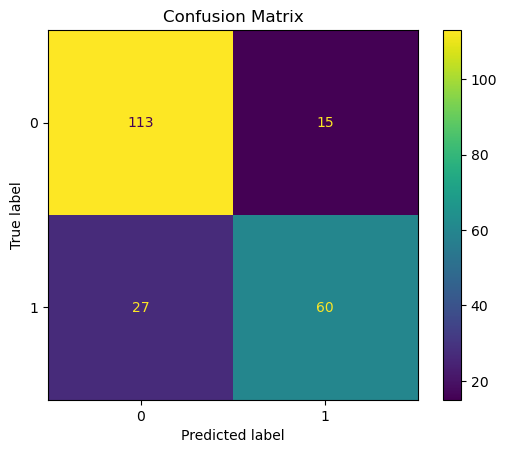

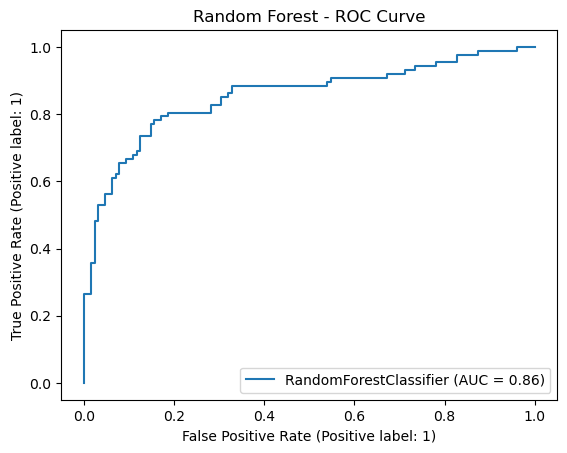

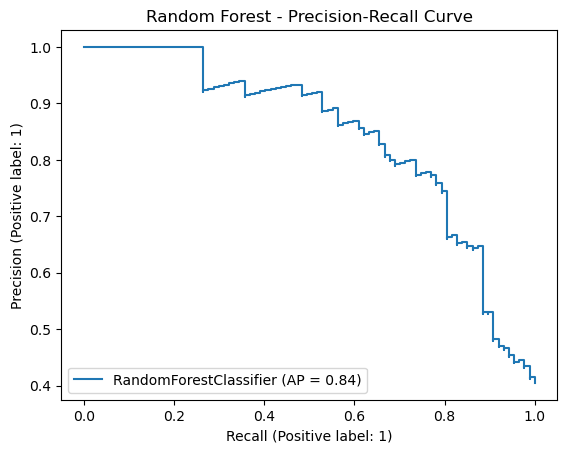

In [19]:
rf_model = RandomForestClassifier(n_estimators=100,  max_depth=5,random_state=42)      
trained_rf_model = train_and_evaluate_classifier(rf_model, X_train, y_train, X_test, y_test, model_name="Random Forest")

## Grid Search Random Forest

=== Grid Search Results ===
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Train Accuracy: 0.8416
=== Random Forest (Best GridSearch) ===
Train Accuracy: 0.906
Test Accuracy: 0.828
Precision: 0.830, Recall: 0.828, F1-score: 0.825
Confusion Matrix:
[[117  11]
 [ 26  61]]


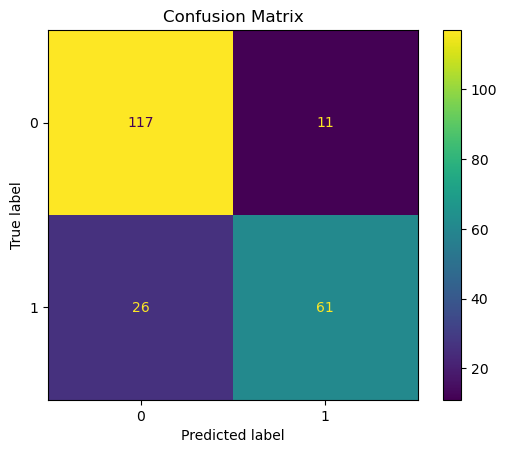

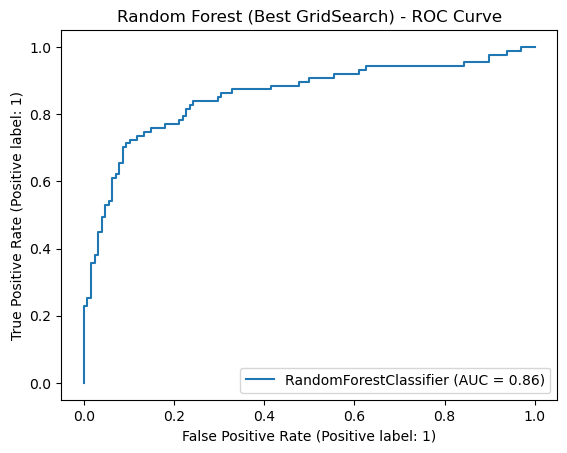

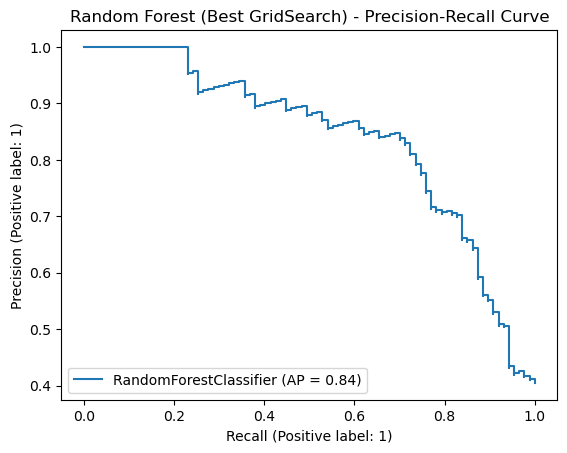

In [20]:
param_grid = {'n_estimators': [10,50,100, 200],'max_depth': [3, 5, 7, None,10],'min_samples_split': [2, 5, 10,15],'min_samples_leaf': [1, 2, 5,10]}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model,param_grid=param_grid,cv=5,scoring='accuracy',n_jobs=-1)

grid_search.fit(X_train, y_train)

print("=== Grid Search Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Train Accuracy: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

trained_best_rf_model = train_and_evaluate_classifier(best_rf_model, X_train, y_train, X_test, y_test, model_name="Random Forest (Best GridSearch)")


## Conclusion

In this project, we tackled the Titanic survival prediction problem using two supervised learning approaches: Logistic Regression and Random Forest. Our pipeline included data cleaning, feature engineering (such as generating a “FamilySize” feature), splitting the dataset into training and testing sets with stratification, and hyperparameter tuning via Grid Search. 

### Key Takeaways:

1. **Logistic Regression (Baseline & Tuned)**  
   - The baseline Logistic Regression model provided a simple, linear approach for understanding how individual features impact survival.  
   - Through Grid Search, we optimized parameters like penalty (L1 vs L2) and the regularization strength C. This tuning enhanced performance and demonstrated how the choice of penalty and regularization can significantly impact the model’s accuracy and generalization.

2. **Random Forest (Baseline & Tuned)**  
   - The baseline Random Forest classifier offered a more flexible, non‑linear approach, often capturing complex interactions missed by a linear model.  
   - Grid Search over n_estimators, max_depth, min_samples_split, and min_samples_leaf allowed us to significantly refine Random Forest’s performance. By systematically evaluating each parameter combination, we identified an optimal configuration that yielded improved test results.

3. **Model Evaluation**  
   - We tracked multiple metrics, including **accuracy**, **precision**, **recall**, **F1‑score**, **ROC curves**, and **precision‑recall curves**. This gave us a comprehensive view of how each model handles false positives and false negatives.  
   - Confusion matrices provided insight into misclassifications, helping us understand where each model could still improve.

### Final Thoughts

- **Model Choice:** While Logistic Regression is interpretable and straightforward, Random Forest generally yielded stronger performance, especially after hyperparameter tuning.  
- **Trade‑Offs:** Proper tuning can significantly improve performance, but it also demands time and computational resources. Balancing the breadth of hyperparameter search with practical constraints is critical in real‑world scenarios.  

Overall, this project highlights the end‑to‑end process of building and refining predictive models—from data preprocessing and feature engineering to model selection, evaluation, and hyperparameter tuning. The final optimized Random Forest stands out for its ability to learn complex patterns in the Titanic dataset and provides a solid benchmark for future improvements.
